In [2]:
cd /home/olga/pureScratch/olgabot-maca/facs/

/mnt/pureScratch/olga/olgabot-maca/facs


In [51]:
import copy
import glob
import itertools
import math

import dask.dataframe as dd
import numpy as np
import pandas as pd

import khtools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [180]:
import numpy as np
import scipy.sparse
from umap.umap_ import (
    smooth_knn_dist, 
    compute_membership_strengths, 
    make_epochs_per_sample, 
    optimize_layout,
    find_ab_params
)
from sklearn.manifold import SpectralEmbedding
from sklearn.utils import check_random_state, check_array
from sklearn.metrics import pairwise_distances

from umap.spectral import spectral_layout


In [4]:
# Defaults from 'sourmash index'

ksize = 21
moltype = 'DNA'

bf_size = 1e5
n_children = 2
scaled = False

from sourmash import signature as sig
from sourmash.sbt import Leaf
from sourmash.sbtmh import SigLeaf, create_sbt_index
from sourmash import sourmash_args
from sourmash.logging import notify

In [5]:
%%time

tree = create_sbt_index(bf_size, n_children=n_children)

folder = '/home/olga/pureScratch/olgabot-maca/facs/sourmash'

signatures = glob.glob(f'{folder}/A10-D*')
print(f"len(signatures): {len(signatures)}")

inp_files = sourmash_args.traverse_find_sigs(signatures)

n = 0
ksizes = set()
moltypes = set()
nums = set()
scaleds = set()

for filename in inp_files:
    notify('loading {}', filename, end='\r')
    siglist = sig.load_signatures(filename,
                                 ksize=ksize,
                                 select_moltype=moltype)
    siglist = list(siglist)
    if not siglist:
        notify('\nwarning: no signatures loaded at given ksize/molecule type from {}', filename)

    # load all matching signatures in this file
    ss = None
    for ss in siglist:
        ksizes.add(ss.minhash.ksize)
        moltypes.add(sourmash_args.get_moltype(ss))
        nums.add(ss.minhash.num)

        if scaled:
            ss.minhash = ss.minhash.downsample_scaled(args.scaled)
        scaleds.add(ss.minhash.scaled)

        leaf = SigLeaf(ss.md5sum(), ss)
        tree.add_node(leaf)
        n += 1

    if not ss:
        continue

    # check to make sure we aren't loading incompatible signatures
    if len(ksizes) > 1 or len(moltypes) > 1:
        error('multiple k-mer sizes or molecule types present; fail.')
        error('specify --dna/--protein and --ksize as necessary')
        error('ksizes: {}; moltypes: {}',
              ", ".join(map(str, ksizes)), ", ".join(moltypes))
        sys.exit(-1)

    if nums == { 0 } and len(scaleds) == 1:
        pass # good
    elif scaleds == { 0 } and len(nums) == 1:
        pass # also good
    else:
        error('trying to build an SBT with incompatible signatures.')
        error('nums = {}; scaleds = {}', repr(nums), repr(scaleds))
        sys.exit(-1)

len(signatures): 16


CPU times: user 424 ms, sys: 24 ms, total: 448 ms
Wall time: 462 ms


In [6]:
# adjacencies = []

# n_neighbors = 5

# for i, leaf in zip(range(10), tree.leaves()):
#     print(leaf)
#     print(leaf.data)
#     print()

In [7]:
%%time

adjacencies = []

n_neighbors = 5

n_parent_levels = math.ceil(math.log2(n_neighbors)) + 1
n_parent_levels

# initialize search queue with top node of tree
matches = []
visited, queue = set(), [0]

ignore_abundance = False
downsample = False

def get_leaves_under(tree, node_position):
    visited, queue = set(), [node_position]
    leaves = []
    
    while queue:
        position = queue.pop(0)
        node = tree.nodes.get(position, None)
        
        if isinstance(node, Leaf):
            leaves.append(node)
        else:
            queue.extend(c.pos for c in tree.children(position))
    return leaves

# while the queue is not empty, load each node and apply search
# function.
while queue:
    position = queue.pop(0)
    node = tree.nodes.get(position, None)
    
    # repair while searching.
    if node is None:
        print("repairing...")
        if position in tree.missing_nodes:
            tree._rebuild_node(node)
            node = tree.nodes[position]
        else:
            continue
            
    # if we have not visited this node before,
    if position not in visited:
        visited.add(position)
        
    # Add 
    if isinstance(node, Leaf):
#         print(node.data)
        n = 1
        upper_internal_node = tree.parent(position)
        while n < n_parent_levels:
            upper_internal_node = tree.parent(upper_internal_node.pos)
            n += 1
#         print("upper_internal_node:", upper_internal_node)
        leaves = get_leaves_under(tree, upper_internal_node.pos)

        
        similarities = []
        for leaf in leaves:
            # Ignore self-simililarity
            if leaf == node:
                continue
#             print(leaf.data)
            similarity = node.data.similarity(leaf.data, 
                                              ignore_abundance=ignore_abundance, 
                                              downsample=downsample)
            similarities.append([node.data.name(), leaf.data.name(), similarity])
        adjacent = sorted(similarities, key=lambda x: x[1])[-n_neighbors:]
#         print(adjacent)
        adjacencies.extend(adjacent)
            
#         break
        
    else:
        queue.extend(c.pos for c in tree.children(position))
    
#     print(node)
#     print(node.data)
#     print()
    visited.add(node)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22.9 ms


In [8]:
leaf.metadata

'db07058d8f0cab09d46f38904596e490'

In [9]:
len(adjacencies)

80

In [10]:
adjacencies[:5]

[['A10-D042044-3_9_M-1-1_S159', 'A10-D043522-3_39_F-1-1_S267', 0.028],
 ['A10-D042044-3_9_M-1-1_S159', 'A10-D043526-3_39_F-1-1_S189', 0.012],
 ['A10-D042044-3_9_M-1-1_S159', 'A10-D045064-3_38_F-1-1_S81', 0.044],
 ['A10-D042044-3_9_M-1-1_S159', 'A10-D045067-3_38_F-1-1_S257', 0.034],
 ['A10-D042044-3_9_M-1-1_S159', 'A10-D045140-3_38_F-1-1_S77', 0.038]]

In [11]:
leaves

In [12]:
tree.children(7)

[NodePos(pos=15, node=<sourmash.sbtmh.SigLeaf object at 0x7f5a27a27048>),
 NodePos(pos=16, node=<sourmash.sbtmh.SigLeaf object at 0x7f5a27a276a0>)]

In [13]:
len(visited)

62

## Try on ALL signatures

In [14]:
%%time

tree = create_sbt_index(bf_size, n_children=n_children)

folder = '/home/olga/pureScratch/olgabot-maca/facs/sourmash'

inp_files = sourmash_args.traverse_find_sigs([folder])

n = 0
ksizes = set()
moltypes = set()
nums = set()
scaleds = set()

for filename in inp_files:
    notify('loading {}', filename, end='\r')
    siglist = sig.load_signatures(filename,
                                 ksize=ksize,
                                 select_moltype=moltype)
    siglist = list(siglist)
    if not siglist:
        notify('\nwarning: no signatures loaded at given ksize/molecule type from {}', filename)

    # load all matching signatures in this file
    ss = None
    for ss in siglist:
        ksizes.add(ss.minhash.ksize)
        moltypes.add(sourmash_args.get_moltype(ss))
        nums.add(ss.minhash.num)

        if scaled:
            ss.minhash = ss.minhash.downsample_scaled(args.scaled)
        scaleds.add(ss.minhash.scaled)

        leaf = SigLeaf(ss.md5sum(), ss)
        tree.add_node(leaf)
        n += 1

    if not ss:
        continue

    # check to make sure we aren't loading incompatible signatures
    if len(ksizes) > 1 or len(moltypes) > 1:
        error('multiple k-mer sizes or molecule types present; fail.')
        error('specify --dna/--protein and --ksize as necessary')
        error('ksizes: {}; moltypes: {}',
              ", ".join(map(str, ksizes)), ", ".join(moltypes))
        sys.exit(-1)

    if nums == { 0 } and len(scaleds) == 1:
        pass # good
    elif scaleds == { 0 } and len(nums) == 1:
        pass # also good
    else:
        error('trying to build an SBT with incompatible signatures.')
        error('nums = {}; scaleds = {}', repr(nums), repr(scaleds))
        sys.exit(-1)

CPU times: user 21min, sys: 12.3 s, total: 21min 13s
Wall time: 21min 21s


In [15]:
# %%time

# adjacencies = tree.nearest_neighbor_adjacencies(n_neighbors=5, ignore_abundance=False, 
#                                                 downsample=False)

In [15]:
%time tree.save("/home/olga/pureScratch/olgabot-maca/facs/tabula-muris-k21.sbt.json")

100623 of 100623 nodes saved3465 of 100623 nodes saved37567 of 100623 nodes saved44595 of 100623 nodes saved93229 of 100623 nodes saved
Finished saving nodes, now saving SBT json file.


CPU times: user 2min 33s, sys: 47.4 s, total: 3min 20s
Wall time: 8min 1s


'/home/olga/pureScratch/olgabot-maca/facs/tabula-muris-k21.sbt.json'

In [18]:
def get_leaves_under(tree, node_position):
    visited, queue = set(), [node_position]
    leaves = []
    
    while queue:
        position = queue.pop(0)
        node = tree.nodes.get(position, None)
        
        if isinstance(node, Leaf):
            yield node
        else:
            queue.extend(c.pos for c in tree.children(position))
#     return leaves

In [20]:
list(get_leaves_under(tree, 37482))

In [21]:
%%time

# initialize search queue with top node of tree

n_neighbors = 5
adjacencies = []
matches = []
visited, queue = set(), [0]

ignore_abundance = False
downsample = False



# while the queue is not empty, load each node and apply search
# function.
while queue:
    position = queue.pop(0)
    node = tree.nodes.get(position, None)
    
    # repair while searching.
    if node is None:
        print("repairing...")
        if position in tree.missing_nodes:
            tree._rebuild_node(node)
            node = tree.nodes[position]
        else:
            continue
            
    # if we have not visited this node before,
    if position not in visited:
        visited.add(position)
        
    # Add 
    if isinstance(node, Leaf):
#         print(node.data)
        n = 1
        upper_internal_node = tree.parent(position)
        while n < n_parent_levels:
            upper_internal_node = tree.parent(upper_internal_node.pos)
            n += 1
#         print("upper_internal_node:", upper_internal_node)
        leaves = get_leaves_under(tree, upper_internal_node.pos)

        
        similarities = []
        for leaf in leaves:
            # Ignore self-simililarity
            if leaf == node:
                continue
#             print(leaf.data)
            similarity = node.data.similarity(leaf.data, 
                                              ignore_abundance=ignore_abundance, 
                                              downsample=downsample)
            similarities.append([node.data.name(), leaf.data.name(), similarity])
        adjacent = sorted(similarities, key=lambda x: x[1])[-n_neighbors:]
#         print(adjacent)
        adjacencies.extend(adjacent)
            
#         break
        
    else:
        queue.extend(c.pos for c in tree.children(position))
    
#     print(node)
#     print(node.data)
#     print()
    visited.add(node)

print(len(adjacencies))

251560
CPU times: user 3min 35s, sys: 700 ms, total: 3min 36s
Wall time: 3min 36s


In [22]:
tree

In [17]:
import igraph as ig

In [ ]:
len(tree)

TypeError: object of type 'SBT' has no len()

In [23]:
n_leaves = sum(1 for _ in tree.leaves())
n_leaves


50312

In [36]:
some_leaves = [leaf for i, leaf in zip(range(5), tree.leaves())]
some_leaves

In [46]:


first_sig = some_leaves[0].data
first_sig

merged_minhashes = copy.copy(first_sig.minhash)
merged_minhashes.get_mins()[:20]

[2249771143781,
 2621703702944,
 6217159659085,
 7215285795798,
 7275716031337,
 7354997587491,
 11399066254007,
 11897683056067,
 12118298264911,
 12127986550362,
 12290763577842,
 13679015317697,
 13790781556633,
 14818047434059,
 15797567115788,
 17454240377307,
 18189175087332,
 19634005123604,
 21542058979523,
 27308576674163]

In [47]:
first_sig.minhash.get_mins()

[2249771143781,
 2621703702944,
 6217159659085,
 7215285795798,
 7275716031337,
 7354997587491,
 11399066254007,
 11897683056067,
 12118298264911,
 12127986550362,
 12290763577842,
 13679015317697,
 13790781556633,
 14818047434059,
 15797567115788,
 17454240377307,
 18189175087332,
 19634005123604,
 21542058979523,
 27308576674163,
 28801856705165,
 30216988107597,
 31112141042562,
 33678889547249,
 34853597721456,
 35534352513422,
 38939650185958,
 39578559175626,
 39841139084330,
 41317309188593,
 41589955194654,
 43019689891776,
 43093935412418,
 43336725764900,
 44737091827026,
 44820450634228,
 48122353443502,
 48293702610686,
 48362485403673,
 48496693091299,
 49128052447956,
 53145210376347,
 54202915184647,
 55366801957319,
 57080164683612,
 59784603567884,
 59847110474853,
 62466542748949,
 65064249737039,
 66324348597656,
 68301692800304,
 69808377506938,
 70156332777316,
 72403545397801,
 73942036129041,
 74166876646176,
 76448607305191,
 78456833730397,
 80085241931896,
 81

In [48]:
for leaf in some_leaves[1:]:
    print(leaf.data.d)
    merged_minhashes = merged_minhashes.merge(leaf.data.minhash)
merged_minhashes.get_mins()[:20]


{'class': 'sourmash_signature', 'license': 'CC0', 'name': 'I15-B001750-3_38_F-1-1_S220', 'filename': '/arg/2/0'}
{'class': 'sourmash_signature', 'license': 'CC0', 'name': 'D8-MAA000871-3_11_M-1-1_S63', 'filename': '/arg/2/0'}
{'class': 'sourmash_signature', 'license': 'CC0', 'name': 'I15-MAA000586-3_8_M-1-1_S260', 'filename': '/arg/2/0'}
{'class': 'sourmash_signature', 'license': 'CC0', 'name': 'B7-MAA001857-3_38_F-1-1_S124', 'filename': '/arg/2/0'}


[399010192761,
 460428543499,
 525389573953,
 917081285437,
 942274509825,
 1206560165194,
 1359790305377,
 1892721786056,
 1901786352660,
 2249771143781,
 2258354650640,
 2389698629948,
 2552942138180,
 2621703702944,
 3208195867768,
 3435543109025,
 3925863031538,
 4014062012901,
 4219114550640,
 5002583233095]

In [49]:
for leaf in some_leaves:
    print(leaf.data.minhash.jaccard(merged_minhashes))

0.218
0.14
0.152
0.336
0.288


In [54]:

def get_leaves(tree):
    for i, node in tree.nodes.items():
        if isinstance(node, (Leaf, SigLeaf)):
            yield i, node

In [66]:
knn_indices = []
knn_dists = []

leaf_to_index = dict((node.data.name(), i) for (i, (position, node)) in enumerate(get_leaves(tree)))
leaf_to_tree_position = dict((node.data.name(), position) for (i, (position, node)) in enumerate(get_leaves(tree)))

index_to_leaf = dict(zip(leaf_to_index.values(), leaf_to_index.keys()))

len(leaf_to_index)

for u, items in itertools.groupby(adjacencies, key=lambda x: x[0]):
    knn_indices_line = []
    knn_dists_line = []
    for u, v, similarity in items:
        knn_indices_line.append(leaf_to_index[v])
        knn_dists_line.append(1-similarity)
    knn_indices.append(knn_indices_line)
    knn_dists.append(knn_dists_line)
print(f"knn_indices: {knn_indices[-10:]}")
print(f"knn_dists: {knn_dists[-10:]}")
knn_dists = np.array(knn_dists)
knn_indices = np.array(knn_indices)

knn_indices: [[50307, 50305, 50297, 50301, 50303], [50309, 50307, 50305, 50297, 50301], [50307, 50305, 50297, 50301, 50303], [50309, 50307, 50297, 50301, 50303], [50307, 50305, 50297, 50301, 50303], [50309, 50305, 50297, 50301, 50303], [50307, 50305, 50297, 50301, 50303], [50307, 50305, 50297, 50301, 50303], [50307, 50305, 50297, 50301, 50303], [50307, 50305, 50297, 50301, 50303]]
knn_dists: [[0.9778139394407598, 0.5865537452356665, 0.5916232897670664, 0.98692031043282, 0.682226850530286], [0.5300652108409426, 0.9920402425804716, 0.6772386593777987, 0.660234167482528, 0.9887831152269003], [0.9781602437008845, 0.5478392578407241, 0.5322415135173466, 0.985198052660397, 0.6666717421966621], [0.6641045046439364, 0.9789997887267935, 0.4498235089138267, 0.9848128448550353, 0.6772386593777987], [0.9723907241140146, 0.7921952958910957, 0.7887829664318484, 0.9927943425894896, 0.8339212803609773], [0.9999661326169812, 0.9789997887267935, 0.9765970894122245, 0.9993956385880218, 0.9920402425804716

In [67]:
leaf_to_index = dict((node.data.name(), i) for i, (position, node) in enumerate(get_leaves(tree)))
leaf_to_position = dict((node.data.name(), position) for position, node in get_leaves(tree))
index_to_leaf = dict(zip(leaf_to_index.values(), leaf_to_index.keys()))

len(leaf_to_index)

50312

In [69]:
# Default in UMAP
# https://github.com/lmcinnes/umap/blob/master///umap/umap_.py#L1246
local_connectivity = 1
set_op_mix_ratio = 1

sigmas, rhos = smooth_knn_dist(
        knn_dists, n_neighbors, local_connectivity=local_connectivity
    )

rows, cols, vals = compute_membership_strengths(
        knn_indices, knn_dists, sigmas, rhos
    )

result = scipy.sparse.coo_matrix(
        (vals, (rows, cols)), shape=(knn_dists.shape[0], knn_dists.shape[0])
    )
result.eliminate_zeros()

transpose = result.transpose()

prod_matrix = result.multiply(transpose)

result = (
    set_op_mix_ratio * (result + transpose - prod_matrix)
    + (1.0 - set_op_mix_ratio) * prod_matrix
)

result.eliminate_zeros()


graph_ = result

In [70]:
n_epochs = 0

graph = graph_.tocoo()
graph.sum_duplicates()
n_vertices = graph.shape[1]

if n_epochs <= 0:
    # For smaller datasets we can use more epochs
    if graph.shape[0] <= 10000:
        n_epochs = 500
    else:
        n_epochs = 200
n_epochs

200

In [71]:
graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
graph.eliminate_zeros()

In [79]:
n_connected_components, labels = scipy.sparse.csgraph.connected_components(graph)


In [80]:
label = 0

In [81]:
np.where(labels == label)

(array([    0,     1,     2,     3,     4,     5,     6,     7, 50296,
        50297, 50298, 50299, 50300, 50301, 50302, 50303, 50304, 50305,
        50306, 50307, 50308, 50309, 50310, 50311]),)

In [82]:
graph_indexes = np.where(labels == label)[0]
signatures = [tree.nodes.get(leaf_to_position[index_to_leaf[i]]).data for i in graph_indexes]
signatures

[SourmashSignature('A8-B002777-3_39_F-1-1_S59', 9d6c2b92),
 SourmashSignature('I15-B001750-3_38_F-1-1_S220', df7bf31a),
 SourmashSignature('D8-MAA000871-3_11_M-1-1_S63', 53f3f179),
 SourmashSignature('I15-MAA000586-3_8_M-1-1_S260', 55afb5b1),
 SourmashSignature('B7-MAA001857-3_38_F-1-1_S124', 81541b5b),
 SourmashSignature('I15-MAA000590-3_9_M-1-1_S203', 87e31ca6),
 SourmashSignature('D9-B000826-3_39_F-1-1_S242', 134a7266),
 SourmashSignature('I15-MAA000439-3_10_M-1-1_S146', b3a05d47),
 SourmashSignature('A10-B000633-3_56_F-1-1_S275', f14a79c7),
 SourmashSignature('P9-MAA001889-3_38_F-1-1_S151', 5c441bc5),
 SourmashSignature('I15-MAA000435-3_10_M-1-1_S160', 33c15141),
 SourmashSignature('P9-MAA001872-3_39_F-1-1_S233', 47015ddb),
 SourmashSignature('D8-MAA001871-3_39_F-1-1_S291', dd6d13cb),
 SourmashSignature('P9-MAA001892-3_38_F-1-1_S225', 87d1ae1f),
 SourmashSignature('I15-B000826-3_39_F-1-1_S57', 94f4d56d),
 SourmashSignature('P9-MAA001894-3_39_F-1-1_S35', 357ae7f6),
 SourmashSignatur

In [83]:
signatures

[SourmashSignature('A8-B002777-3_39_F-1-1_S59', 9d6c2b92),
 SourmashSignature('I15-B001750-3_38_F-1-1_S220', df7bf31a),
 SourmashSignature('D8-MAA000871-3_11_M-1-1_S63', 53f3f179),
 SourmashSignature('I15-MAA000586-3_8_M-1-1_S260', 55afb5b1),
 SourmashSignature('B7-MAA001857-3_38_F-1-1_S124', 81541b5b),
 SourmashSignature('I15-MAA000590-3_9_M-1-1_S203', 87e31ca6),
 SourmashSignature('D9-B000826-3_39_F-1-1_S242', 134a7266),
 SourmashSignature('I15-MAA000439-3_10_M-1-1_S146', b3a05d47),
 SourmashSignature('A10-B000633-3_56_F-1-1_S275', f14a79c7),
 SourmashSignature('P9-MAA001889-3_38_F-1-1_S151', 5c441bc5),
 SourmashSignature('I15-MAA000435-3_10_M-1-1_S160', 33c15141),
 SourmashSignature('P9-MAA001872-3_39_F-1-1_S233', 47015ddb),
 SourmashSignature('D8-MAA001871-3_39_F-1-1_S291', dd6d13cb),
 SourmashSignature('P9-MAA001892-3_38_F-1-1_S225', 87d1ae1f),
 SourmashSignature('I15-B000826-3_39_F-1-1_S57', 94f4d56d),
 SourmashSignature('P9-MAA001894-3_39_F-1-1_S35', 357ae7f6),
 SourmashSignatur

In [128]:
from sourmash import signature as sig

In [130]:
%%time

centroid_signatures = []

for label in range(n_connected_components):
    graph_indexes = np.where(labels == label)[0]
    signatures = [tree.nodes.get(leaf_to_position[index_to_leaf[i]]).data for i in graph_indexes]
    
    first_sig = signatures[0]
    merged_signatures = sig.SourmashSignature(first_sig.minhash, name=label)
    for s in signatures[1:]:
        merged_signatures.minhash = merged_signatures.minhash.merge(s.minhash)
    centroid_signatures.append(merged_signatures)

centroid_signatures

CPU times: user 820 ms, sys: 308 ms, total: 1.13 s
Wall time: 1.28 s


In [131]:
merged_signatures.__dict__

{'d': {'class': 'sourmash_signature', 'name': 3143, 'license': 'CC0'},
 'minhash': <sourmash._minhash.MinHash at 0x7f5a1c82b918>}

In [132]:
# sig = signatures[0]
# sig

In [136]:
s.minhash.merge

<method-wrapper '__iadd__' of sourmash._minhash.MinHash object at 0x7f5a01aab5d0>

In [137]:
type(s)

sourmash.signature.SourmashSignature

In [138]:
from sourmash.compare import compare_all_pairs

In [139]:
# centroid_signatures

In [140]:
len(centroid_signatures)

3144

In [141]:
for i, sig1 in enumerate(centroid_signatures[:3]):
    for j, sig2 in enumerate(centroid_signatures[:3]):
        print(i, j)
        print('\t', sig1.minhash.similarity(sig2.minhash))

0 0
	 0.9999999685372574
0 1
	 0.35567425370389527
0 2
	 0.28088037096497787
1 0
	 0.35567425370389527
1 1
	 0.9999999290104784
1 2
	 0.441256685128136
2 0
	 0.28088037096497787
2 1
	 0.441256685128136
2 2
	 1.0


In [146]:
%time component_similarity_matrix = compare_all_pairs(centroid_signatures, ignore_abundance=ignore_abundance, n_jobs=32)

CPU times: user 1h 8min 9s, sys: 4min 44s, total: 1h 12min 54s
Wall time: 1h 23min 7s


In [148]:
component_similarity_matrix.shape

(3144, 3144)

In [155]:
%%time

component_embedding = SpectralEmbedding
    n_components=2, affinity="precomputed"
).fit_transform(component_similarity_matrix)
component_embedding /= component_embedding.max()

CPU times: user 0 ns, sys: 43min 54s, total: 43min 54s
Wall time: 38 s


## Convert component embedding to sample embedding

In [176]:
meta_embedding = component_embedding

component_labels = labels

dim = 2
result = np.empty((graph.shape[0], dim), dtype=np.float32)

for label in range(n_connected_components):
    component_graph = graph.tocsr()[labels == label, :].tocsc()
    component_graph = component_graph[:, labels == label].tocoo()

    distances = pairwise_distances([meta_embedding[label]], meta_embedding)
    data_range = distances[distances > 0.0].min() / 2.0

    if component_graph.shape[0] < 2 * dim:
        result[component_labels == label] = (
                random_state.uniform(
                    low=-data_range,
                    high=data_range,
                    size=(component_graph.shape[0], dim),
                )
                + meta_embedding[label]
        )
        continue

    diag_data = np.asarray(component_graph.sum(axis=0))
    # standard Laplacian
    # D = scipy.sparse.spdiags(diag_data, 0, graph.shape[0], graph.shape[0])
    # L = D - graph
    # Normalized Laplacian
    I = scipy.sparse.identity(component_graph.shape[0], dtype=np.float64)
    D = scipy.sparse.spdiags(
        1.0 / np.sqrt(diag_data),
        0,
        component_graph.shape[0],
        component_graph.shape[0],
    )
    L = I - D * component_graph * D

    k = dim + 1
    num_lanczos_vectors = max(2 * k + 1,
                              int(np.sqrt(component_graph.shape[0])))
    try:
        eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(
            L,
            k,
            which="SM",
            ncv=num_lanczos_vectors,
            tol=1e-4,
            v0=np.ones(L.shape[0]),
            maxiter=graph.shape[0] * 5,
        )
        order = np.argsort(eigenvalues)[1:k]
        component_embedding = eigenvectors[:, order]
        expansion = data_range / np.max(np.abs(component_embedding))
        component_embedding *= expansion
        result[component_labels == label] = (
                component_embedding + meta_embedding[label]
        )
    except scipy.sparse.linalg.ArpackError:
        warn(
            "WARNING: spectral initialisation failed! The eigenvector "
            "solver\nfailed. This is likely due to too small an eigengap."
            " Consider\nadding some noise or jitter to your data.\n\n"
            "Falling back to random initialisation!"
        )
        result[component_labels == label] = (
                random_state.uniform(
                    low=-data_range,
                    high=data_range,
                    size=(component_graph.shape[0], dim),
                )
                + meta_embedding[label]
        )

IndexError: index 24 is out of bounds for axis 0 with size 24

In [169]:
expansion = 10.0 / np.abs(component_embedding).max()
spectral_embedding = (component_embedding * expansion).astype(
    np.float32
) + random_state.normal(
    scale=0.0001, size=[graph.shape[0], 2]
).astype(
    np.float32
)

ValueError: operands could not be broadcast together with shapes (3144,2) (50312,2) 

In [166]:
spectral_embedding.shape

NameError: name 'spectral_embedding' is not defined

### Optimize embedding

In [181]:
a, b = find_ab_params(1, 0)


In [177]:
%%time


epochs_per_sample = make_epochs_per_sample(graph.data, n_epochs)

head = graph.row
tail = graph.col

random_embedding_optimized = optimize_layout(
        random_embedding,
        random_embedding,
        head,
        tail,
        n_epochs,
        n_vertices,
        epochs_per_sample,
        a,
        b,
        rng_state,
        gamma,
        initial_alpha,
        negative_sample_rate,
        verbose=verbose,
    )

NameError: name 'a' is not defined

## Do random embedding

In [191]:
random_state = check_random_state(0)

random_embedding = random_state.uniform(
            low=-10.0, high=10.0, size=(graph.shape[0], dim)
        ).astype(np.float32)

In [192]:
%%time

INT32_MIN = np.iinfo(np.int32).min + 1
INT32_MAX = np.iinfo(np.int32).max - 1

rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)
gamma = 1.0
initial_alpha = 1.0
negative_sample_rate = 0.5
verbose = True
epochs_per_sample = make_epochs_per_sample(graph.data, n_epochs)

head = graph.row
tail = graph.col

random_embedding_optimized = optimize_layout(
        random_embedding,
        random_embedding,
        head,
        tail,
        n_epochs,
        n_vertices,
        epochs_per_sample,
        a,
        b,
        rng_state,
        gamma,
        initial_alpha,
        negative_sample_rate,
        verbose=verbose,
    )

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
CPU times: user 14.9 s, sys: 0 ns, total: 14.9 s
Wall time: 14.7 s


In [193]:
random_embedding_optimized

array([[ 3.2981803 , -0.92651725],
       [ 3.2982755 , -0.92638385],
       [ 3.2983341 , -0.92664   ],
       ...,
       [ 3.298633  , -0.9267428 ],
       [ 3.298915  , -0.92685866],
       [ 3.2990875 , -0.92698616]], dtype=float32)

In [194]:
random_embedding_optimized.shape

(50312, 2)

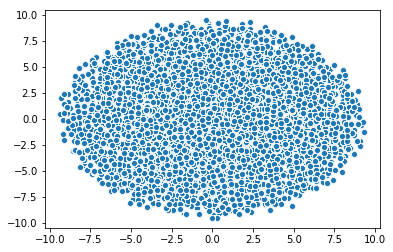

In [197]:
fig, ax = plt.subplots(figsize=(6, 4))

x = random_embedding_optimized[:, 0]
y = random_embedding_optimized[:, 1]
sns.scatterplot(x, y)

In [160]:
first_sig.minhash.jaccard(merged_minhashes)

1.0

In [ ]:
g = ig.Graph(directed=True)
g.add_vertices([u for (u, v, weight) in adjacencies])  # this adds n_leaves vertices
g.add_edges([(u, v) for (u, v, weight) in adjacencies])
g.es['weight'] = [weight for (u, v, weight) in adjacencies]

In [ ]:
g

In [ ]:
layout = g.layout_fruchterman_reingold()

In [1]:
layout

NameError: name 'layout' is not defined

### Do Leiden clustering

In [ ]:
partition leidenalg.find_partition(g, partition_type, **partition_kwargs)
# store output into adata.obs
groups = np.array(part.membership)